#### [ 딥페이크 사진 검출 ]<hr>
- mini_project_deepface_임정현_  .ipynb  
    - 이미지 전처리  
        - 컬러 + resize + flatten
    - 전처리 후 csv 파일 (train / valid / test)

[1] 모듈 로딩 및 데이터 준비<hr>

In [ ]:
## [1-1] 모듈 로딩
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim




REAL_DIR = './Data/Final Dataset/Real'
FAKE_DIR = './Data/Final Dataset/Fake'
SAVE_DIR = './DeepFake/models'
os.makedirs(SAVE_DIR, exist_ok=True)


In [64]:
## [1-2] 데이터 로딩

## 경로 설정
DEEPFAKE_DIR = './Data/Final Dataset/Fake'
REAL_DIR = './Data/Final Dataset/Real'

## 이미지 파일 리스트
deepfake_file_list = os.listdir(DEEPFAKE_DIR)
real_file_list = os.listdir(REAL_DIR)

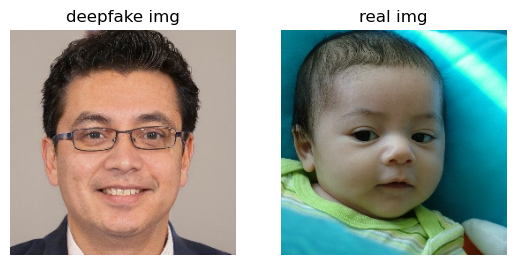

In [65]:
## 이미지 확인
## cv2.imread() : 이미지 파일을 읽어서 ndarray로 반환
sample_fake = cv2.imread(os.path.join(DEEPFAKE_DIR, deepfake_file_list[0]))
sample_real = cv2.imread(os.path.join(REAL_DIR, real_file_list[0]))

## 이미지 시각화
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(sample_fake, cv2.COLOR_BGR2RGB))
plt.title('deepfake img')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(sample_real, cv2.COLOR_BGR2RGB))
plt.title('real img')
plt.axis('off')
plt.show()


[2] 데이터셋 전처리
<hr>

In [66]:
## [2-1] 이미지 경로 및 라벨링 정보 수집
real_image_paths = [os.path.join(REAL_DIR, fn) for fn in os.listdir(REAL_DIR)]
fake_image_paths = [os.path.join(FAKE_DIR, fn) for fn in os.listdir(FAKE_DIR)]

paths = real_image_paths + fake_image_paths
labels = [0]*len(real_image_paths) + [1]*len(fake_image_paths)

print(f"real : {len(real_image_paths)}, fake : {len(fake_image_paths)}")

real : 5890, fake : 6986


In [67]:
## [2-2] train, valid, test 데이터 분리
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


p_trainval, p_test, y_trainval_lbl, y_test_lbl = train_test_split(paths,
                                                          labels,
                                                          test_size=0.10,
                                                          random_state=42,
                                                          stratify=labels)

valid_ratio = 0.10 / (1 - 0.10)

p_train, p_valid, y_train_lbl, y_valid_lbl = train_test_split(p_trainval,
                                                      y_trainval_lbl,
                                                      test_size=valid_ratio,
                                                      random_state=42,
                                                      stratify=y_trainval_lbl)

print(f"train : {len(p_train)}, valid : {len(p_valid)}, test : {len(p_test)}")

train : 10300, valid : 1288, test : 1288


In [68]:
## [2-3] 이미지 전처리 및 정규화 수치 뽑아내기(Train에만 - 누수방지)

sum_x  = np.zeros(3, dtype=np.float64)   # 채널별 합
sum_x2 = np.zeros(3, dtype=np.float64)   # 채널별 제곱합
cnt = 0
bad = 0

for i, p in enumerate(p_train, 1):
    img = cv2.imread(p, cv2.IMREAD_COLOR)   # BGR, (H,W,3)
    if img is None:
        bad += 1
        continue

    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
    x = img.astype(np.float32) / 255.0      # (128,128,3)

    x2d = x.reshape(-1, 3)                  # (N,3)
    sum_x  += x2d.sum(axis=0)
    sum_x2 += (x2d * x2d).sum(axis=0)
    cnt += x2d.shape[0]                     # 픽셀 개수 N=128*128

    if i % 100 == 0:
        print(f'[정규화] 진행상황 : {i}/{len(p_train)}')

mean = sum_x / max(cnt, 1)                  # (3,)
var  = (sum_x2 / max(cnt, 1)) - (mean * mean)
std  = np.sqrt(np.maximum(var, 1e-8))       # (3,)

print("mean:", mean.round(4), "std:", std.round(4), "bad images:", bad)


[정규화] 진행상황 : 100/10300
[정규화] 진행상황 : 200/10300
[정규화] 진행상황 : 300/10300
[정규화] 진행상황 : 400/10300
[정규화] 진행상황 : 500/10300
[정규화] 진행상황 : 600/10300
[정규화] 진행상황 : 700/10300
[정규화] 진행상황 : 800/10300
[정규화] 진행상황 : 900/10300
[정규화] 진행상황 : 1000/10300
[정규화] 진행상황 : 1100/10300
[정규화] 진행상황 : 1200/10300
[정규화] 진행상황 : 1300/10300
[정규화] 진행상황 : 1400/10300
[정규화] 진행상황 : 1500/10300
[정규화] 진행상황 : 1600/10300
[정규화] 진행상황 : 1700/10300
[정규화] 진행상황 : 1800/10300
[정규화] 진행상황 : 1900/10300
[정규화] 진행상황 : 2000/10300
[정규화] 진행상황 : 2100/10300
[정규화] 진행상황 : 2200/10300
[정규화] 진행상황 : 2300/10300
[정규화] 진행상황 : 2400/10300
[정규화] 진행상황 : 2500/10300
[정규화] 진행상황 : 2600/10300
[정규화] 진행상황 : 2700/10300
[정규화] 진행상황 : 2800/10300
[정규화] 진행상황 : 2900/10300
[정규화] 진행상황 : 3000/10300
[정규화] 진행상황 : 3100/10300
[정규화] 진행상황 : 3200/10300
[정규화] 진행상황 : 3300/10300
[정규화] 진행상황 : 3400/10300
[정규화] 진행상황 : 3500/10300
[정규화] 진행상황 : 3600/10300
[정규화] 진행상황 : 3700/10300
[정규화] 진행상황 : 3800/10300
[정규화] 진행상황 : 3900/10300
[정규화] 진행상황 : 4000/10300
[정규화] 진행상황 : 4100/10300
[정규화] 진행상황 : 4200/10300
[

In [ ]:
## 전처리한 파라미터 저장
import joblib
SAVE_DIR = './DeepFake/models'
os.makedirs(SAVE_DIR, exist_ok=True)
joblib.dump({'mean': mean, 'std': std},
            os.path.join(SAVE_DIR, 'fake_preprocess_params.joblib'))
print("저장 ok")

저장 ok


In [70]:
## [2-4] 전처리해서 feature/target csv 파일로 저장

## 함수 기능 : 이미지 전처리
## 함수 이름 : build_feature_target
## 매개 변수 : split_paths, split_labels, img_size, mean, std, save_csv_path=None
## 반환 결과 : 없음

def build_feature_target(split_paths, split_labels, img_size, mean, std, save_csv_path=None):
    if len(split_paths) != len(split_labels):
        raise ValueError(f"길이 불일치: paths={len(split_paths)}, labels={len(split_labels)}")

    X_list, y_list = [], []
    bad = 0

    mean = np.array(mean, dtype=np.float32).reshape(1, 1, 3)
    std  = np.array(std,  dtype=np.float32).reshape(1, 1, 3)

    f = open(save_csv_path, "w", encoding="utf-8") if save_csv_path else None

    for p, y in zip(split_paths, split_labels):
        img = cv2.imread(p, cv2.IMREAD_COLOR)
        if img is None:
            bad += 1
            continue

        img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
        x = img.astype(np.float32) / 255.0      # (S,S,3)
        x = (x - mean) / std                    # (S,S,3)
        x = x.reshape(-1)                       # (S*S*3,)

        X_list.append(x)
        y_list.append(int(y))

        if f is not None:
            f.write(",".join(f"{v:.6f}" for v in x) + f",{int(y)}\n")

    if f is not None:
        f.close()

    X = np.stack(X_list).astype(np.float32)
    y = np.array(y_list).astype(np.int64)
    return X, y, bad

  

In [71]:
## 전처리 함수 사용
x_train, y_train,bad1 = build_feature_target(p_train, y_train_lbl, 128, mean=mean, std=std, save_csv_path=os.path.join(SAVE_DIR, "train.csv"))
x_valid, y_valid,bad2 = build_feature_target(p_valid, y_valid_lbl, 128, mean=mean, std=std, save_csv_path=os.path.join(SAVE_DIR, "valid.csv"))
x_test, y_test,bad3 = build_feature_target(p_test, y_test_lbl, 128, mean=mean, std=std, save_csv_path=os.path.join(SAVE_DIR, "test.csv"))

print("bad : ", bad1, bad2, bad3)
print(x_train.shape, y_train.shape)
                                        

bad :  0 0 0
(10300, 49152) (10300,)


[4] 학습 준비<hr>

In [72]:
## [4-1] 클래스 정의 : 커스텀 데이터셋


## 클래스이름 : CustomDataset
## 부모클래스 : Dataset
## 오버라이딩 : __init__, __len__, __getitem__
class CustomDataset(Dataset):
    def __init__(self, x,y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [73]:
## [4-2] 데이터로더 생성
BATCH_SIZE = 256
trainDS = CustomDataset(x_train, y_train)
validDS = CustomDataset(x_valid, y_valid)
testDS = CustomDataset(x_test, y_test)

trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=0)
validDL = DataLoader(validDS, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=0)
testDL = DataLoader(testDS, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=0)

In [74]:
## [4-3] 모델 클래스 생성

## 클래스 이름 : DeepFakeModel
## 부모 클래스 : nn.Module
## 입력층 : 196608
## 은닉층1 : 512
## 은닉층2 : 256
## 은닉층3 : 128
## 출력층 : 2
## 중간중간에 batchNorm + Dropout 적용
## 활성화 함수 : ReLU
## Dropout 비율 : 0.3, 0.2, 0.1, 0.1

class DeepFakeModel(nn.Module):
    def __init__(self, in_dim=49152, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, num_classes),
        )
    def forward(self,x):
        return self.net(x)

[5] 학습 진행 <hr>

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

DEVICE: cuda


In [76]:
## [5-1] train_one_epoch 함수 생성

## 함수 이름 : train_one_epoch
## 함수 기능 : 1 epoch 학습 수행
## 매개 변수 : model, dataloader, loss_fn, optimizer, device
## 반환 결과 : epoch_loss, epoch_acc, epoch_f1

def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    y_true_all, y_pred_all = [], []

    for x, y in dataloader:
        x, y = x.to(device), y.to(device).long()

        optimizer.zero_grad()
        logits = model(x)                # (B,)
        loss = loss_fn(logits, y)              # ✅ BCE는 y float
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)

        
        pred = logits.argmax(dim=1)
        correct += (pred == y.long()).sum().item()
        total += y.size(0)

        y_true_all.append(y.detach().cpu().numpy().ravel().astype(int))
        y_pred_all.append(pred.detach().cpu().numpy().ravel().astype(int))

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    epoch_f1 = f1_score(y_true_all, y_pred_all, pos_label=1, zero_division=0)
    return total_loss / total, correct / total, epoch_f1
    

In [117]:
## [5-2] evaluate 함수 생성


## 함수 이름 : evaluate
## 함수 기능 : 검증 또는 테스트 수행
## 매개 변수 : model, dataloader, loss_fn, device, calc_auc=True

@torch.no_grad()
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    y_true_all, y_pred_all = [], []

    for X, y in dataloader:
        X, y = X.to(device), y.to(device).long()

        logits = model(X)          # (B,)
        loss = loss_fn(logits, y)

        total_loss += loss.item() * y.size(0)

        pred = logits.argmax(dim=1)
        correct += (pred == y.long()).sum().item()
        total += y.size(0)

        y_true_all.append(y.detach().cpu().numpy().ravel().astype(int))
        y_pred_all.append(pred.detach().cpu().numpy().ravel().astype(int))

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    epoch_f1 = f1_score(y_true_all, y_pred_all, pos_label=1, zero_division=0)
    return total_loss / total, correct / total, epoch_f1

In [118]:
## [5-3] 관련 인스턴스 생성
model = DeepFakeModel(in_dim=49152, num_classes=2).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [ ]:
## [5-4] 학습 설정
EPOCHS = 100
PATIENCE = 3 ## 조기 종료 기준

best_valid_acc = -1.0
best_epoch = -1
pat_cnt = 0

best_model_path = os.path.join(SAVE_DIR, 'fake_model.pth')

## train_loss, valid_loss, train_acc, valid_acc, train_f1, valid_f1
history = {'train_loss': [], 'valid_loss': [],
           'train_acc': [], 'valid_acc': [],
           'train_f1': [], 'valid_f1': []}

In [120]:
## 현재 학습 돌리려는 데이터 확인
print(f"학습 데이터 수 : {len(trainDS)}")
print(f"검증 데이터 수 : {len(validDS)}")


학습 데이터 수 : 10300
검증 데이터 수 : 1288


In [121]:
## [5-5] 모델 학습 및 검증 수행
for epoch in range(1, EPOCHS+1):
    train_loss, train_acc, train_f1 = train_one_epoch(model, trainDL, loss_fn, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1 = evaluate(model, validDL, loss_fn, DEVICE)

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc)
    history['train_f1'].append(train_f1)
    history['valid_f1'].append(valid_f1)

    print(f"[Epoch {epoch}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} | "
          f"Valid Loss: {valid_loss:.4f}, Acc: {valid_acc:.4f}, F1: {valid_f1:.4f}\n")

    # 모델 저장 및 조기 종료 체크
    # f1 기준 모델 저장
    # if valid_f1 > best_valid_acc:
    #     torch.save(model.state_dict(), best_model_path)
    #     best_valid_acc = valid_f1
    #     best_epoch = epoch
    #     pat_cnt = 0
    # else:
    #     pat_cnt += 1
    #     if pat_cnt >= PATIENCE:
    #         print(f"조기 종료: {epoch} epoch에서 종료")
    ## ACC 기준 모델 저장
    if valid_acc > best_valid_acc:
        torch.save(model.state_dict(), best_model_path)
        best_valid_acc = valid_acc
        best_epoch = epoch
        pat_cnt = 0
    else:
        pat_cnt += 1
        if pat_cnt >= PATIENCE:
            print(f"조기 종료: {epoch} epoch에서 종료")
            break
print(f"최고 성능 모델은 {best_epoch} epoch에서 저장됨 (Valid Acc: {best_valid_acc:.4f})")

        
    

[Epoch 1/100] Train Loss: 0.6337, Acc: 0.6422, F1: 0.6885 | Valid Loss: 0.5845, Acc: 0.6879, F1: 0.7509

[Epoch 2/100] Train Loss: 0.5686, Acc: 0.7000, F1: 0.7482 | Valid Loss: 0.5348, Acc: 0.7228, F1: 0.7748

[Epoch 3/100] Train Loss: 0.5271, Acc: 0.7184, F1: 0.7595 | Valid Loss: 0.5097, Acc: 0.7298, F1: 0.7743

[Epoch 4/100] Train Loss: 0.4851, Acc: 0.7504, F1: 0.7817 | Valid Loss: 0.4930, Acc: 0.7547, F1: 0.7907

[Epoch 5/100] Train Loss: 0.4414, Acc: 0.7803, F1: 0.8035 | Valid Loss: 0.4615, Acc: 0.7710, F1: 0.7939

[Epoch 6/100] Train Loss: 0.4154, Acc: 0.8021, F1: 0.8212 | Valid Loss: 0.4661, Acc: 0.7772, F1: 0.8022

[Epoch 7/100] Train Loss: 0.3885, Acc: 0.8178, F1: 0.8334 | Valid Loss: 0.4607, Acc: 0.7772, F1: 0.8057

[Epoch 8/100] Train Loss: 0.3668, Acc: 0.8297, F1: 0.8455 | Valid Loss: 0.4583, Acc: 0.7780, F1: 0.7966

[Epoch 9/100] Train Loss: 0.3506, Acc: 0.8396, F1: 0.8534 | Valid Loss: 0.4429, Acc: 0.7787, F1: 0.7945

[Epoch 10/100] Train Loss: 0.3136, Acc: 0.8599, F1: 0.8

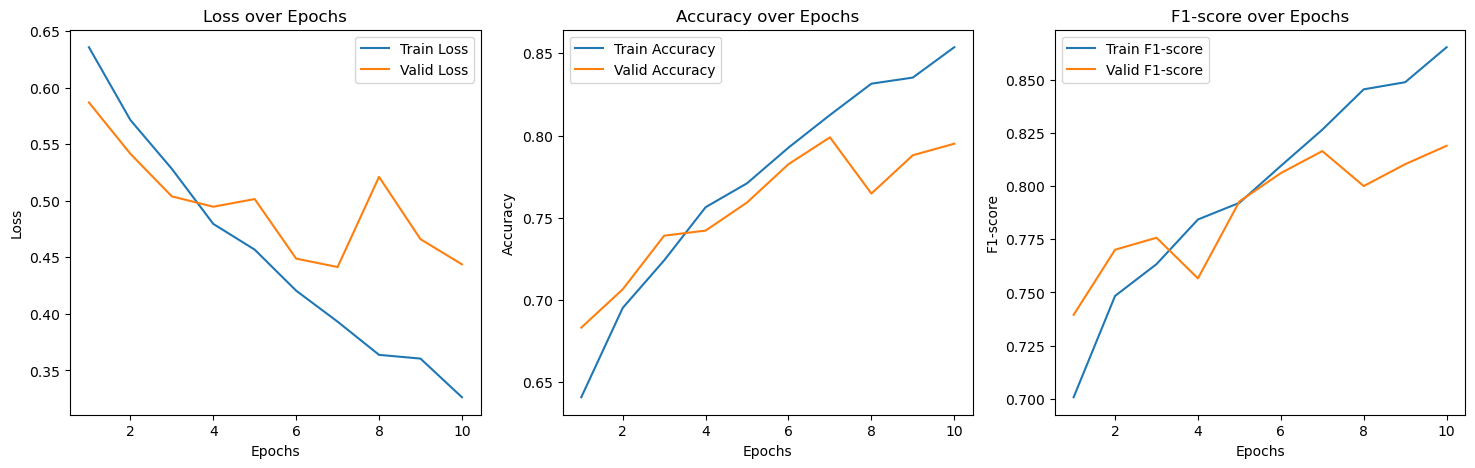

In [113]:
## 시각화
## Loss, Accuracy, F1-score 변화 그래프 그리기
epochs_range = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['valid_loss'], label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
plt.plot(epochs_range, history['valid_acc'], label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['train_f1'], label='Train F1-score')
plt.plot(epochs_range, history['valid_f1'], label='Valid F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('F1-score over Epochs')
plt.legend()
plt.show()

In [122]:
## [5-6] 테스트 데이터에 대한 최종 평가
# 베스트 모델 로드
best_model_path = os.path.join(SAVE_DIR, 'fake_model.pth')
model.load_state_dict(torch.load(best_model_path))
test_loss, test_acc, test_f1 = evaluate(model, testDL, loss_fn, DEVICE)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}")

C:\Users\jhjh5\AppData\Local\Temp\ipykernel_10544\3118744420.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Loss: 0.4746, Test Acc: 0.7648, Test F1: 0.7868


In [123]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import joblib

def load_and_predict(
    model,
    evaluate_fn,
    testDL,
    loss_fn,
    device,
    save_dir="./DeepFake/models",
    model_filename="fake_model.pth",
    params_filename="fake_preprocess_params.joblib",
    img_size=128,
    fake_samples=None,
    real_samples=None,
):
    """
    기능:
      - 모델 가중치 로드
      - 테스트 평가(evaluate)
      - 전처리 파라미터(mean/std) 로드
      - 샘플 이미지들에 대해 pred / P(real) / P(fake) 출력

    반환:
      dict: {
        "test": {"loss":..., "acc":..., "f1":...},
        "fake_results": [(path, pred, p_real, p_fake), ...],
        "real_results": [(path, pred, p_real, p_fake), ...],
      }
    """
    # -------------------------
    # 1) 모델 로드
    # -------------------------
    best_model_path = os.path.join(save_dir, model_filename)
    state = torch.load(best_model_path, map_location=device)
    model.load_state_dict(state)

    # -------------------------
    # 2) 테스트 평가
    # -------------------------
    test_loss, test_acc, test_f1 = evaluate_fn(model, testDL, loss_fn, device)

    # -------------------------
    # 3) 전처리 파라미터 로드 (컬러 3채널)
    # -------------------------
    preprocess_path = os.path.join(save_dir, params_filename)
    preprocess_params = joblib.load(preprocess_path)

    mean = np.asarray(preprocess_params["mean"], dtype=np.float32)
    std  = np.asarray(preprocess_params["std"],  dtype=np.float32)

    if mean.shape != (3,) or std.shape != (3,):
        raise ValueError(f"mean/std shape 이상: mean={mean.shape}, std={std.shape}")

    mean_ = mean.reshape(1, 1, 3)
    std_  = std.reshape(1, 1, 3)

    # -------------------------
    # 4) 내부 전처리/예측 함수
    # -------------------------
    def preprocess_image(image_path):
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError(f"이미지를 불러올 수 없습니다: {image_path}")

        img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
        x = img.astype(np.float32) / 255.0
        x = (x - mean_) / std_
        x = x.reshape(-1).astype(np.float32)
        return torch.from_numpy(x).unsqueeze(0)

    @torch.no_grad()
    def predict_one(image_path):
        model.eval()
        x_tensor = preprocess_image(image_path).to(device)
        logits = model(x_tensor)                  # (1,2)
        prob = F.softmax(logits, dim=1)[0]        # (2,)
        pred = int(prob.argmax().item())
        prob_fake = float(prob[1].item())
        prob_real = float(prob[0].item())
        return pred, prob_real, prob_fake

    # -------------------------
    # 5) 샘플 예측
    # -------------------------
    if fake_samples is None:
        fake_samples = []
    if real_samples is None:
        real_samples = []

    label_name = {0: "REAL", 1: "FAKE"}

    fake_results = []
    real_results = []

    print(f"[TEST] loss={test_loss:.4f}, acc={test_acc:.4f}, f1={test_f1:.4f}\n")

    print("=== FAKE SAMPLES ===")
    for p in fake_samples:
        pred, pr, pf = predict_one(p)
        fake_results.append((p, pred, pr, pf))
        print(f"{p} | pred={label_name[pred]} | P(real)={pr:.4f} P(fake)={pf:.4f}")

    print("\n=== REAL SAMPLES ===")
    for p in real_samples:
        pred, pr, pf = predict_one(p)
        real_results.append((p, pred, pr, pf))
        print(f"{p} | pred={label_name[pred]} | P(real)={pr:.4f} P(fake)={pf:.4f}")

    return {
        "test": {"loss": test_loss, "acc": test_acc, "f1": test_f1},
        "fake_results": fake_results,
        "real_results": real_results,
    }




fake_samples = ["./DeepFake/test/FAKE_musk01.png"]
real_samples = ["./DeepFake/test/REAL_musk01.png"]

result = load_and_predict(
    model=model,
    evaluate_fn=evaluate,
    testDL=testDL,
    loss_fn=loss_fn,
    device=DEVICE,
    save_dir="./DeepFake/models",
    img_size=128,
    fake_samples=fake_samples,
    real_samples=real_samples,
)


C:\Users\jhjh5\AppData\Local\Temp\ipykernel_10544\1052749372.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(best_model_path, map_location=device)


[TEST] loss=0.4746, acc=0.7648, f1=0.7868

=== FAKE SAMPLES ===
./DeepFake/test/FAKE_musk01.png | pred=FAKE | P(real)=0.1582 P(fake)=0.8418

=== REAL SAMPLES ===
./DeepFake/test/REAL_musk01.png | pred=REAL | P(real)=0.5833 P(fake)=0.4167
